# Google Drive Setup


Google drive setup to get and save data with the model running on Google Colab. If running locally, the drive_home variable is not needed on the paths.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
drive_home = "drive/My Drive/Smartcare/"

# Imports and Functions

In [ ]:
import pandas as pd
import json
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from skimage.transform import resize
import tensorflow as tf
import time
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from numpy.random import seed



To avoid some caching problems seen in Google Colab with keras, this function is used to clear the sessions on every run

In [ ]:
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Given the X's, Y's and an unique identifier (for saving). The images from the dataset are saved into a folder by using this function

In [ ]:
def salvaImagens(previsores, classe, nome):
  # Salva o dataset em imagens
  stress_path = drive_home+"dataset-imagens/stress/"+nome+"/"
  normal_path = drive_home+"dataset-imagens/normal/"+nome+"/"

  for i, img in enumerate(previsores):
    if classe[i] == 1:
      path = stress_path
    else:
      path = normal_path
    fi = plt.imshow(img.reshape(128,128))
    plt.axis('off')
    plt.savefig(path+str(i)+".png")


Id for Logging

Timestamp is captured to distinguish every train experiment in the logs




In [ ]:
id = int(time.time())
arquivo = "modelCNN-%d"%(id)
print(arquivo)

In order to try to make the experiments the most reproductable we could, the numpy and tensorflow seeds were defined manually. Even though variations still exist due gpu running and the data augmentation. 

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

# Data Processing

Image datasets are loaded and rescaled to 128x128.

In [ ]:

x = np.load(drive_home+"dados/2DpathData.npy")
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

x_resize = []
for image in x:
    x_resize.append(resize(image ,(128,128)))
x_resize = np.array(x_resize)
x = x_resize

y = np.load(drive_home+"dados/2DpathData-y.npy")


x, x_teste, y, y_teste = train_test_split(x, y, shuffle=False)

Length of the train image dataset

In [ ]:
len(x)

150

Length of the test image dataset

In [ ]:
len(x_teste)

50

The validation data used to evaluate the model is also loaded and resized to 128x128

In [ ]:
x_resize = []
x_val = np.load(drive_home+"dados/x-validacao.npy")
for image in x_val:
    x_resize.append(resize(image ,(128,128)))
x_val = np.array(x_resize).reshape(x_val.shape[0], 128, 128, 1)
print(x_val.shape)

y_val = np.load(drive_home+"dados/y-validacao.npy")

(20, 128, 128, 1)


# Convolutional Neural Network

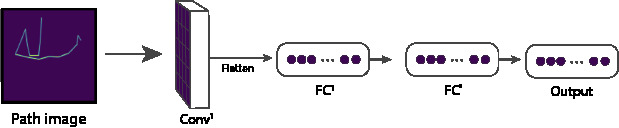

The paremeters of the model like filters, activation functions on the layers, and the train loss and optimizer algorithm were choosen empirically 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, activation='relu', input_shape=(x.shape[1], x.shape[2], 1), kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data Augmentation

Data is generated by rotating the images at a maximum of 3 degrees and flipping horizontally and vertically. The data generator parameters and batch size were empirically choosen.

In [ ]:
            gerador_treinamento = ImageDataGenerator(    rotation_range = 3,
                                                         horizontal_flip = True,
                                                         vertical_flip = True,
                                                     )
            
            gerador_teste = ImageDataGenerator(          rotation_range = 3,
                                                         horizontal_flip = True,
                                                         vertical_flip = True)
                
            base_treinamento = gerador_treinamento.flow(x=x, y=y, batch_size = 64)
            base_teste = gerador_teste.flow(x=x_teste, y=y_teste, batch_size = 64)

In [ ]:
#salvaImagens(x_teste, y_teste, 'teste')

# Data Analysis

Plots samples of data generated by data augmentation

In [ ]:
try:
	#plt.subplots()
	fig, ax = plt.subplots(nrows=2, ncols=2)
	for row in ax:
		for col in row:
			batch = base_treinamento.next()
	# convert to unsigned integers for viewing
			image = batch[0][0]
			col.imshow(image.reshape(128,128))

	plt.show()
except:
	print("Erro")

Plots samples of the train dataset

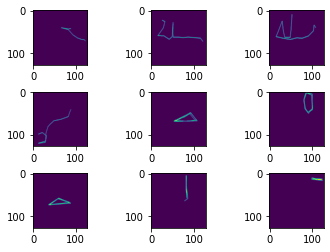

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  image = x[i]
  plt.imshow(image.reshape(128,128))
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.5)
# show the figure
plt.show()

Plots samples of the validation dataset

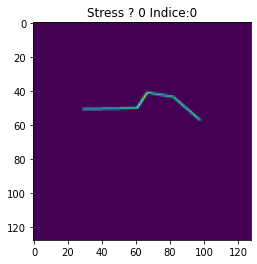

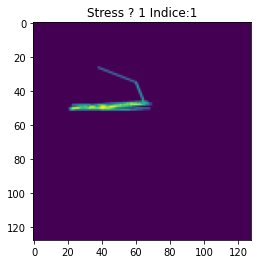

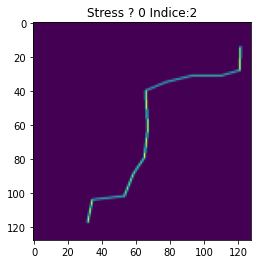

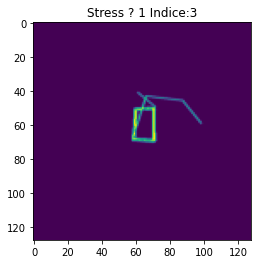

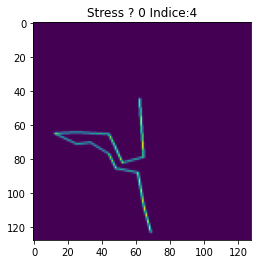

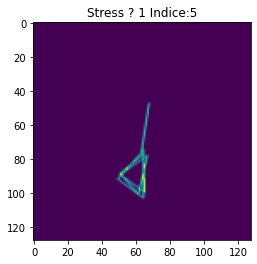

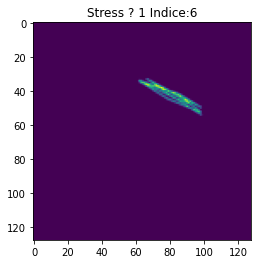

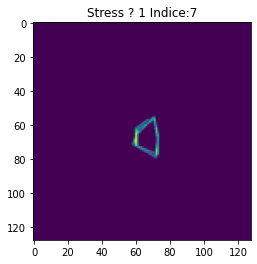

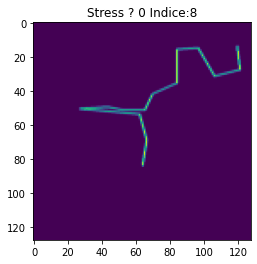

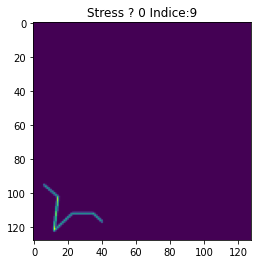

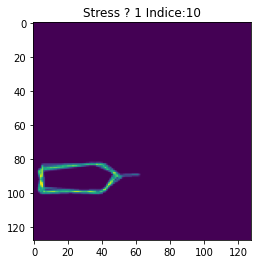

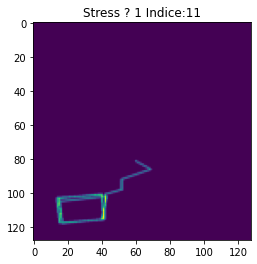

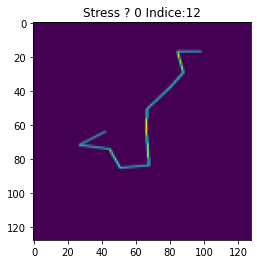

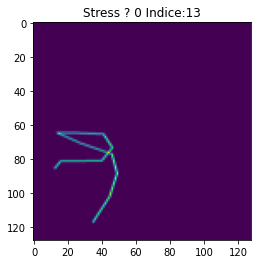

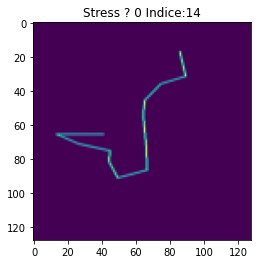

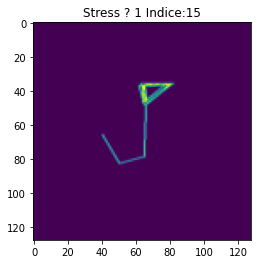

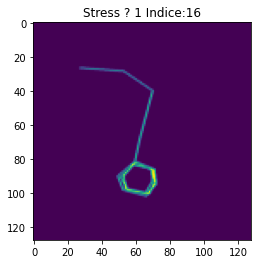

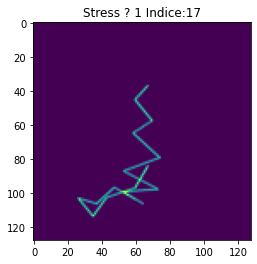

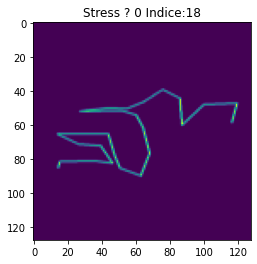

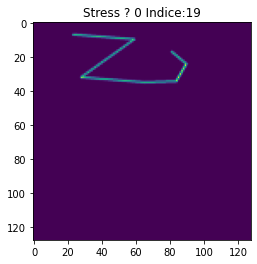

In [ ]:
for i in range(len(x_val)):
  image = x_val[i]
  plt.title("Stress ? "+str(y_val[i])+" Indice:"+str(i))
  plt.imshow(image.reshape(128,128))
  plt.show()

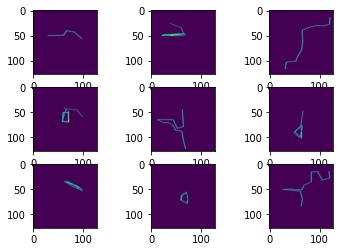

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  image = x_val[i]
  plt.imshow(image.reshape(128,128))
# show the figure
plt.show()

# Model Training

In [ ]:
h = model.fit(base_treinamento, steps_per_epoch= len(base_treinamento),
                                    epochs = 150, validation_data = base_teste,
                                    validation_steps = len(base_teste),
                                    verbose=1, shuffle=False)

The charts shown below were essential to empiracally choose the parameters.

Accuracy per epoch chart

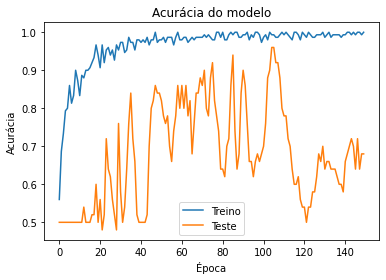

In [ ]:
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Acurácia do modelo')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treino', 'Teste'], loc='best')
    plt_accuracy = plt.gcf()
    plt_accuracy.savefig("%sgraficos/%s-accuracy.png"%(drive_home, arquivo))
    plt.show() 

Learning curve chart

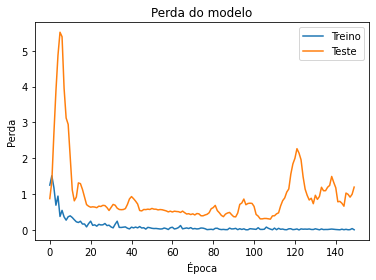

In [ ]:
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Perda do modelo')
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend(['Treino', 'Teste'], loc='best')
    plt_accuracy = plt.gcf()
    plt.savefig("%sgraficos/%s-loss.png"%(drive_home, arquivo))
    plt.show() 

# Model Evaluation and Results

In [ ]:
#keras.models.load_model(drive_home+"dados/modelCNN-1606236872.h5")
print(drive_home+"dados/modelCNN-1606236872.h5")

To be sure about the model performance, by predicting the validation dataset using the tranining mode, metrics were calculated (revoke, precision, f1 score)

In [ ]:
model.evaluate(x_val, y_val, verbose=0)

In [ ]:
y_pred = np.round(model.predict(x_val),0)
print(y_pred)
y_true = np.array(y_val)
y_true = y_true.reshape(y_true.shape[0], 1)
diff = y_pred - y_true
plt.plot(diff)
plt.show()

plt.imshow(x_val[17].reshape(128, 128))
plt.show()
print(y_pred[17] == y[17])

Scikit learn was used to calculate the f1 score

In [ ]:
fscore = f1_score(y_true, y_pred)
print(fscore)

How many samples marked as wandering really were ? (Recall)

In [ ]:
recall = recall_score(y_true, y_pred)
print(recall)

From all the data, how much were correctly marked as wandering ? (Precision)

In [ ]:
precision = precision_score(y_true, y_pred)
print(precision)

# Logs and Resets

Adds into the log the metrics of the experiment

In [ ]:
with open(drive_home+'experiments.txt', 'a') as f:
  f.write("\n f1:%f - recall:%f - precision:%f - %s.h5"%(fscore, recall, precision, arquivo))


Saves the experiment trained model

In [ ]:
model.save(drive_home+'dados/modelCNN-%d.h5'%(id))

Resets keras sessions

In [ ]:
reset_keras()